In [1]:
!nvidia-smi

Thu Nov 23 13:52:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   35C    P8    14W / 320W |      0MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import random
import pickle
import joblib
import json
import time
from collections import deque
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import warnings
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler

from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score
from ast import literal_eval
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from pytorch_metric_learning import losses
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics.functional.classification import multiclass_recall
from torcheval.metrics.functional import multiclass_accuracy
from torcheval.metrics.functional import multiclass_auprc
from torcheval.metrics.functional import multiclass_auroc

c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 9861
seed_everything(seed = SEED)

In [15]:
class Contrastive_Embedding(nn.Module): #supervised contrastive learning
    def __init__(self, input_size, drop_rate, hidden_unit_sizes):
        super(Contrastive_Embedding, self).__init__()
        self.input_size = input_size
        self.hidden_unit_sizes = hidden_unit_sizes
        
        leaky_relu = nn.LeakyReLU()
        
        encoder = [nn.Linear(input_size, hidden_unit_sizes[0]),
                   nn.BatchNorm1d(hidden_unit_sizes[0]),
                   nn.Dropout(drop_rate),
                   leaky_relu]
    
        
        for i in range(1,len(hidden_unit_sizes)):
        
                encoder.append(nn.Linear(hidden_unit_sizes[i-1], hidden_unit_sizes[i]))
                encoder.append(nn.BatchNorm1d(hidden_unit_sizes[i]))
                encoder.append(nn.Dropout(drop_rate))
                encoder.append(leaky_relu)
                
        self.encoder = nn.Sequential(
            *encoder
        )
        

    def forward(self, x):
        latent = self.encoder(x)
        return latent

In [5]:
#Dataset

pd.set_option('display.max_columns',None)
dataset = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/MIMIC_pipeline/Case Labeling/mimic_df.csv.gz', index_col = 0, compression='gzip')

In [6]:
recovery_situation = {0, 1, 2, 3}
deterioration_situation = {0, 1, 3}

    
recover_state = dataset[dataset['classes'].isin(recovery_situation)].groupby('stay_id')['classes'].nunique()
recover_state = recover_state[recover_state == len(recovery_situation)].index

recover_set = dataset[dataset['stay_id'].isin(recover_state)]

deterioration_state = dataset[dataset['classes'].isin(deterioration_situation)].groupby('stay_id')['classes'].nunique()
deterioration_state = deterioration_state[deterioration_state == len(deterioration_situation)].index

deterioration_set = dataset[dataset['stay_id'].isin(deterioration_state)]

def filter_classes_with_condition(df):
    filtered_df = df[df['classes'].isin([0, 1, 3])]
    return filtered_df

deterioration_set = filter_classes_with_condition(deterioration_set)

deterioration_grouped = deterioration_set.groupby('stay_id')

# 조건에 맞는 stay_id를 찾는 함수
def deterioration_filter_stay_ids(group):
    # 처음 3개 관측치의 Annotation이 모두 'no_circ'인지 확인
    if all(group.head(3)['Annotation'] == 'no_circ'):
        # 마지막 관측치의 classes가 3인지 확인
        if group.tail(1)['classes'].iloc[0] == 3:
            return True
    return False

# 조건을 만족하는 stay_id 필터링
valid_stay_ids = [name for name, group in deterioration_grouped if deterioration_filter_stay_ids(group)]
deterioration_df = deterioration_set[deterioration_set.stay_id.isin(valid_stay_ids)].copy()

recover_grouped = recover_set.groupby('stay_id')

def recovery_filter_stay_ids(group):
    # 처음 3개 관측치의 Annotation이 모두 'no_circ'인 경우만 고려
    if all(group.head(3)['Annotation'] == 'no_circ'):
        # 'classes'가 2인 마지막 관측치 찾기
        last_class_2_index = group[group['classes'] == 2].index.max()
        if pd.notna(last_class_2_index):
            # 해당 인덱스까지의 데이터 반환
            return group.loc[:last_class_2_index]
    return pd.DataFrame()

# 조건을 만족하는 데이터 필터링
recovery_df = pd.concat([recovery_filter_stay_ids(group) for _, group in recover_grouped])

In [7]:
target_data = pd.concat([recovery_df, deterioration_df])

In [30]:
def param():
    USER_NAME = 'JE'                  
    SEED      = 9861
    batch_size= 128
    epoch     = 120
    lr        = 0
    drop_rate = 0.223573505016481
    hidden = {
        'hidden' : [98, 65, 40]
        
     }
    temp = 0.3137977865167101
    return hidden, SEED, batch_size, lr, epoch, drop_rate, temp


def load_data(df):
    x = df.drop(['subject_id', 'stay_id', 'hadm_id','Annotation','classes', 'CIRC_next_12h'], axis= 1)
    y = df['classes']
    return x, y


def train(trial, search = False):
    global emb_model, results_loss, optimizer, scheduler
    
    hidden, SEED, batch_size, lr, epoch, drop_rate, temp = param()
    
    # search parameters
    if search == True:
        for idx, i in enumerate(hidden):
            num_layers = trial.suggest_int(f'num_layer_{idx}', 2, 3) # layer 수
            for i in range(num_layers):
                hidden['hidden'].append(trial.suggest_int(f'h{i+1}', 60, 100)) # node 수
        epoch     = trial.suggest_int('epoch', 70,100)
        lr        = 0.0006
        drop_rate = trial.suggest_uniform('drop_rate', 0.56, 0.65)
        temp      = trial.suggest_uniform('temp', 0.1, 0.5)
    hidden['hidden'] = sorted(hidden['hidden'], reverse=True)       
    print(hidden)
    print('learning_rate : ', lr, "\nepoch : ", epoch, "\ndrop_rate : ", drop_rate, "\ntemperature : ", temp)
    
    results_loss = {
    'epoch_by_trn'          : [],
    'epoch_by_val'          : []
    }
    mimic_df = target_data.copy()
    
    #undersampling
    #circ가 한번이라도 오지 않은 환자 언더 샘플링
    
    # sty=[]
    # for stay_id, group_data in mimic_df.groupby('stay_id'):
    #     if (group_data['classes'] == 0).all():
    #         sty.append(stay_id)
    
    # mimic_df = mimic_df[~(mimic_df.stay_id.isin(sty))]
    
    # print(mimic_df['classes'].value_counts().sort_index())
    
    trn_x, trn_y  = load_data(mimic_df)
    
    # data leakage 조심
    scaler        = MinMaxScaler()
    trn_sclaed_x  = scaler.fit_transform(trn_x)

    trn_tensor_x  = torch.FloatTensor(trn_sclaed_x)
    trn_tensor_y  = torch.LongTensor(trn_y.values) 
    
  
    
    n_feat = trn_tensor_x.shape[1]
        
    train_dataset = TensorDataset(trn_tensor_x, trn_tensor_y)


    
    y_train_indices = mimic_df.index


    y_train = [mimic_df.classes[i] for i in y_train_indices]


    class_sample_count = np.array(
        [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
    


    weight = 1. / class_sample_count
    
    samples_weight = np.array([weight[t] for t in y_train])
    samples_weight = torch.from_numpy(samples_weight)
    


    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train_loader  = torch.utils.data.DataLoader(dataset= train_dataset, batch_size=batch_size, shuffle=False, sampler=sampler, drop_last=True)

    # 모델 정의
    emb_model = Contrastive_Embedding(n_feat, drop_rate, hidden['hidden']).to(device)
    print(emb_model)
    
    contrastive_loss = losses.SupConLoss(temperature=temp)
    # mse_loss = nn.MSELoss()
    optimizer = optim.RMSprop(emb_model.parameters(), lr= 0)
    
    scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=50, T_mult=1, eta_max=0.0001,  T_up=50, gamma=0.5)
    
    for i in range(1, epoch+1):
        emb_model.train()
        
        train_loss = {'cont_loss' :[],
                      'mse_loss'  :[],
                      'total_loss':[],
                      'epoch_by'  :[]}
        
        # current_lr = optimizer.param_groups[0]["lr"]
        start = time.time()
        
        for j, (X, y)  in enumerate(train_loader):
            
            X  = X.to(device)
            y  = y.to(device)

            optimizer.zero_grad()
            
            latent = emb_model.forward(X)
            
            # loss_mse = mse_loss(out, X)
            
            y =  y.type(torch.LongTensor)
            loss_cont = contrastive_loss(latent, y)
            
            
            
            loss_cont.backward()
            optimizer.step()
            
            train_loss['cont_loss'].append(loss_cont.item())

        tr_cont_mean = np.array(train_loss['cont_loss']).mean()
        
        scheduler.step()  
        results_loss['epoch_by_trn'].append(tr_cont_mean)
        
        end = time.time()
        if i % 1 == 0:
            print(f'epoch {i}  time: {end - start:.4f}sec trn_contrastive: {tr_cont_mean: .4f}')
    
    return tr_cont_mean


In [20]:
def make_embeded_df(model_name): 
    print()
    print('Start Getting the latent space vector(Train, Valid sample)')
    
    mimic_df = target_data.copy()
    print(len(mimic_df))
    information = mimic_df[['subject_id', 'stay_id', 'hadm_id']]
    trn_x, trn_y  = load_data(mimic_df)
    
    scaler        = MinMaxScaler()
    trn_sclaed_x  = scaler.fit_transform(trn_x)

    trn_tensor_x  = torch.FloatTensor(trn_sclaed_x)
    trn_tensor_y  = torch.LongTensor(trn_y.values) 
    
    
    n_feat = trn_tensor_x.shape[1]
        
    train_dataset = TensorDataset(trn_tensor_x, trn_tensor_y)
    for_latent_loader_trn  = torch.utils.data.DataLoader(dataset= train_dataset, batch_size=trn_tensor_x.shape[0], shuffle=False, drop_last=False)
    
    
    start = time.time()
    model_name.eval()
    with torch.no_grad():
        for X_l, y_l  in for_latent_loader_trn: # Full batch
                
                X_l  = X_l.to(device)
                latent_vector_train = model_name.forward(X_l)
                
                emb_train_x = pd.DataFrame(np.array(latent_vector_train.cpu()), index = original_index)
                emb_train = pd.concat([emb_train_x, pd.DataFrame(np.array(y_l))], axis = 1)
                # emb_train = pd.concat([information, emb_train], axis = 1)
    end = time.time()            
    print()
    print('End, Time consume(min):{}'.format((end - start)/60))  
    
    return emb_train

In [21]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [22]:
# warnings.filterwarnings("ignore")
# import os
# import optuna

# # os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]= '0'
# os.environ['CUDA_LAUNCH_BLOCKING']= '1'
# n_gpu             = 1
# device            = torch.device('cuda:0')

# # Set parameters

# study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction="minimize")
# study.optimize(train, n_trials = 5)  # expected trial 30 -> 41 hour= 1.7 days

# pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
# complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]


# print("Study statistics: ")
# print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: ", trial.value)

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

In [31]:
warnings.filterwarnings("ignore")
import os
import optuna

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
os.environ['CUDA_LAUNCH_BLOCKING']= '1'
n_gpu             = 1
device            = torch.device('cuda:0')

model = train(trial=1, search = False)

{'hidden': [98, 65, 40]}
learning_rate :  0.0006 
epoch :  120 
drop_rate :  0.223573505016481 
temperature :  0.3137977865167101
Contrastive_Embedding(
  (encoder): Sequential(
    (0): Linear(in_features=214, out_features=98, bias=True)
    (1): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.223573505016481, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=98, out_features=65, bias=True)
    (5): BatchNorm1d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.223573505016481, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=65, out_features=40, bias=True)
    (9): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.223573505016481, inplace=False)
    (11): LeakyReLU(negative_slope=0.01)
  )
)
epoch 1  time: 78.0996sec trn_contrastive:  4.9233
epoch 2  time: 77.5303sec trn_contra

KeyboardInterrupt: 

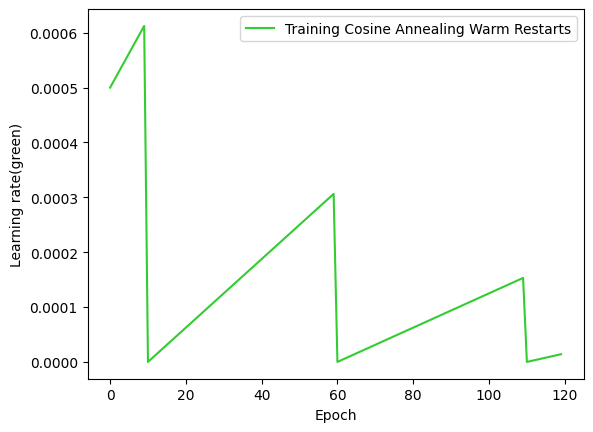

In [25]:
lrs = []
for i in range(120):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()


plt.plot(range(120), lrs, color = 'limegreen',  label = 'Training Cosine Annealing Warm Restarts')
plt.xlabel('Epoch')
plt.ylabel('Learning rate(green)')
plt.legend()
plt.show()

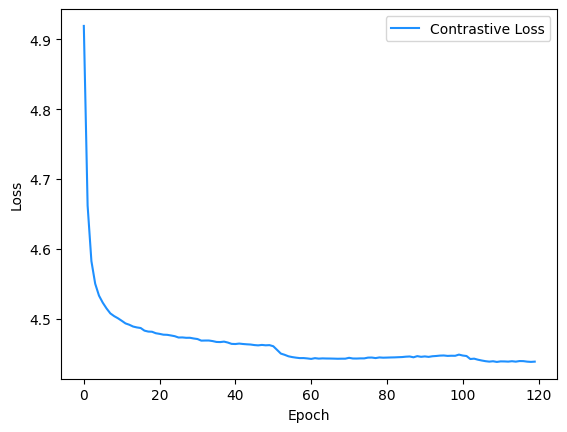

In [26]:
plt.plot(range(120),results_loss['epoch_by_trn'], color = 'dodgerblue', label = 'Contrastive Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
torch.save({"model_state_dict": model.state_dict(),
            },
           f"Contrastive_Embedding_Net(1117AE).pt")

In [54]:
print(model)

Contrastive_Embedding(
  (encoder): Sequential(
    (0): Linear(in_features=222, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.56, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.56, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.56, inplace=False)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.56, inplace=False)
    (3): LeakyReLU(negative_slope=0.

In [18]:
emb_df = make_embeded_df(model)


Start Getting the latent space vector(Train, Valid sample)
818286

End, Time consume(min):0.09841051896413168


In [20]:
sample = pd.concat([dataset[['subject_id', 'stay_id', 'hadm_id']].reset_index(drop=True), emb_df.reset_index(drop=True)], axis = 1, ignore_index=True)
sample = sample.rename(columns = {0: 'subject_id', 1:'stay_id', 2:'hadm_id'})
sample

,subject_id,stay_id,hadm_id,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184
0,15332791,30003598,20683754,-0.001014,-0.009162,-0.009464,-0.001002,-0.000988,-0.009106,-0.009416,-0.009061,-0.009510,-0.000999,-0.001019,-0.009394,-0.009065,-0.000993,-0.009465,-0.009292,-0.009414,-0.009063,-0.001027,-0.009478,-0.009288,-0.009373,-0.001029,-0.009483,-0.008518,-0.009234,-0.009363,-0.009054,-0.009238,-0.001008,-0.009250,-0.009453,-0.009230,-0.009493,-0.009371,-0.009301,-0.009320,-0.001029,-0.009140,-0.001023,-0.001028,-0.009337,-0.009065,-0.009471,-0.009558,-0.009213,-0.009430,-0.009309,-0.009456,-0.009356,-0.009362,-0.001025,-0.001021,-0.001035,-0.009370,-0.009389,-1.033548e-03,-0.009285,-0.009166,-0.009313,-0.009333,-0.009467,-0.008837,-0.009275,-0.008142,-0.009303,-0.009602,-0.009177,-0.009367,-0.007936,-0.009302,-0.009367,-0.009460,-0.001046,-0.001006,-0.001023,-0.009440,-0.009383,-0.009410,-0.001024,-0.009276,-0.009462,-0.009312,-0.009202,-0.009274,-0.009259,-0.009174,-0.009142,-0.009488,-0.009448,-0.009330,-0.001023,-0.008025,-0.009363,-0.000988,-0.001019,-0.009590,-0.009362,-0.009161,-0.009398,-0.008683,-0.001001,-0.009491,-0.009557,-0.009275,-0.009317,-0.009408,-0.001010,-0.001008,-0.009300,-0.009451,-0.009306,-0.009206,-0.001004,-0.009422,-0.001021,-0.001012,-0.009244,-0.001021,-0.001018,-0.009380,-0.001021,-0.009279,-0.009660,-0.001005,-0.009348,-0.001009,-0.009439,-0.001048,-0.009281,-0.001029,-0.009491,-0.009398,-0.009379,-0.009317,-0.001008,-0.009379,-0.001011,-0.000994,-0.008322,-0.009528,-0.009209,-0.009175,-0.001023,-0.009396,-0.009037,-0.001002,-0.009413,-0.001009,-0.009416,-0.009291,-0.009421,-0.009411,-0.009273,-0.009410,-0.009351,-0.009103,-0.001015,-0.009423,-0.001018,-0.009166,-0.009409,-0.009423,-0.009473,-0.001024,-0.009293,-0.009384,-0.001020,-0.009617,-0.009393,-0.009280,-0.009501,-0.001018,-0.001024,-0.009511,-0.009249,-0.009229,-0.009345,-0.009345,-0.001010,-0.001001,1
1,15332791,30003598,20683754,-0.001003,-0.007288,-0.007451,-0.000990,-0.000978,-0.007154,-0.007484,-0.007209,-0.007576,-0.000989,-0.001007,-0.007447,-0.007117,-0.000982,-0.007538,-0.007402,-0.007486,-0.007225,-0.001018,-0.007545,-0.007335,-0.007459,-0.001019,-0.007549,-0.006784,-0.007350,-0.007437,-0.007102,-0.007348,-0.000998,-0.007353,-0.007526,-0.007352,-0.007554,-0.007345,-0.007303,-0.007397,-0.001018,-0.007278,-0.001013,-0.001017,-0.007417,-0.007215,-0.007545,-0.007584,-0.007325,-0.007496,-0.007334,-0.007505,-0.007454,-0.007461,-0.001013,-0.001012,-0.001024,-0.007456,-0.007464,-1.024011e-03,-0.007380,-0.007281,-0.007422,-0.007356,-0.007525,-0.006911,-0.007310,-0.006353,-0.007400,-0.007627,-0.007290,-0.007451,-0.006227,-0.007362,-0.007451,-0.007529,-0.001035,-0.000995,-0.001014,-0.007501,-0.007395,-0.007488,-0.001014,-0.007338,-0.007538,-0.007412,-0.007328,-0.007379,-0.007363,-0.007286,-0.007254,-0.007497,-0.007525,-0.007428,-0.001013,-0.006308,-0.007450,-0.000977,-0.001007,-0.007611,-0.007436,-0.007283,-0.007480,-0.006836,-0.000990,-0.007506,-0.007531,-0.007374,-0.007347,-0.007466,-0.001000,-0.000998,-0.007390,-0.007505,-0.007408,-0.007319,-0.000994,-0.007464,-0.001010,-0.001001,-0.007288,-0.001009,-0.001007,-0.007459,-0.001010,-0.007384,-0.007669,-0.000995,-0.007356,-0.000998,-0.007506,-0.001037,-0.007388,-0.001018,-0.007477,-0.007395,-0.007461,-0.007384,-0.000997,-0.007403,-0.001001,-0.000982,-0.006583,-0.007574,-0.007276,-0.007202,-0.001013,-0.007479,-0.007162,-0.000990,

In [22]:
sample.to_csv('embedding_data.csv')